https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format?select=Train.csv

In [1]:
import pandas as pd
import numpy as np

# Predictive model on IMDB review

In [2]:
data = pd.read_csv('Train.csv')
train = data.copy()

data = pd.read_csv('Test.csv')
test = data.copy()

data = pd.read_csv('Valid.csv')
val = data.copy()

In [3]:
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
train.duplicated().sum()

np.int64(277)

In [6]:
test.duplicated().sum()

np.int64(5)

In [7]:
val.duplicated().sum()

np.int64(2)

In [8]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
val.drop_duplicates(inplace=True)

In [9]:
train.isnull().sum()

text     0
label    0
dtype: int64

In [10]:
test.isnull().sum()

text     0
label    0
dtype: int64

In [11]:
val.isnull().sum()

text     0
label    0
dtype: int64

In [12]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
port_stemmer = PorterStemmer()

from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Howlingwolfs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Howlingwolfs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Howlingwolfs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
def preprocessing(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r'[^\w\s,.!?]', '', text)  # removes most emojis & symbols
    text = text.split()
    text = [port_stemmer.stem(word) for word in text if not word in stop_words]
    return text

In [14]:
train["processed"] = train["text"].apply(preprocessing)
test["processed"] = test["text"].apply(preprocessing)
val["processed"] = val["text"].apply(preprocessing)

In [15]:
train['tokens'] = train['text'].apply(word_tokenize)
val['tokens'] = val['text'].apply(word_tokenize)
test['tokens'] = test['text'].apply(word_tokenize)

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train['tokens'])  # Fit only on training data

train_sequences = tokenizer.texts_to_sequences(train['tokens'])
val_sequences = tokenizer.texts_to_sequences(val['tokens'])
test_sequences = tokenizer.texts_to_sequences(test['tokens'])

In [16]:
max_length = 180  # Adjust based on your data

# Apply padding and truncation
train_x = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_x = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_x = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [17]:
train_y = np.array(train['label'])
val_y = np.array(val['label'])
test_y = np.array(test['label'])

In [18]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(39723, 180)
(4998, 180)
(4995, 180)


In [19]:
import tensorflow
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD
from keras import regularizers

In [20]:
model = models.Sequential()

# Layers
model.add(layers.Dense(500, activation='relu', input_shape = (180, )))
model.add(BatchNormalization(momentum=0.99, epsilon=0.01))
model.add(Dropout(0.2))

model.add(layers.Dense(500, activation='relu'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.01))
model.add(Dropout(0.2))

model.add(layers.Dense(500, activation='relu'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.01))
model.add(Dropout(0.2))

# Last Layer
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

model.summary()

C:\Users\Howlingwolfs\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 500)                 │          90,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 500)                 │           2,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 500)                 │           2,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 500)                 │           2,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 598,001 (2.28 MB)

 Trainable params: 595,001 (2.27 MB)

 Non-trainable params: 3,000 (11.72 KB)

In [21]:
history = model.fit(train_x, train_y, epochs=50)
results = model.evaluate(test_x, test_y)

Epoch 1/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5107 - loss: 0.7548
Epoch 2/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5313 - loss: 0.6968
Epoch 3/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5398 - loss: 0.6922
Epoch 4/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5533 - loss: 0.6875
Epoch 5/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5704 - loss: 0.6806
Epoch 6/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5992 - loss: 0.6661
Epoch 7/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6222 - loss: 0.6497
Epoch 8/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6502 - loss: 0.6260
Epoch 9/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6711 - loss: 0.6046
Epoch 10/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6919 - loss: 0.5791
Epoch 11/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7115 - loss: 0.5576
Epoch 12/50
1242/12

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

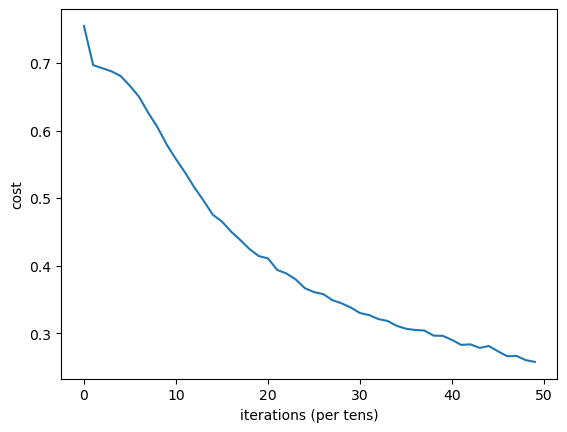



Accuracy on training set is 0.8924804329872131

Accuracy on test set is 0.5065065026283264


In [23]:
plt.plot(np.squeeze(history.history["loss"]))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
# plt.title("Learning rate =" + str(learning_rate))
plt.show()
    
print("\n\nAccuracy on training set is {}".format(history.history["accuracy"][-1]))
print("\nAccuracy on test set is {}".format(results[1]))

In [24]:
predicting = model.predict(val_x, verbose=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   


In [25]:
predicted_classes = (predicting > 0.5).astype("int32")

In [26]:
df = pd.DataFrame({
    'Text': [x for x in val['text']],
    'Actual Label': [x for x in val['label']],
    'Predicted Label': [x for x in predicted_classes]
})

In [37]:
df.head(20)

,Text,Actual Label,Predicted Label
0,It's been about 14 years since Sharon Stone aw...,0,[0]
1,someone needed to make a car payment... this i...,0,[1]
2,The Guidelines state that a comment must conta...,0,[1]
3,This movie is a muddled mish-mash of clichés f...,0,[0]
4,Before Stan Laurel became the smaller half of ...,0,[0]
5,This is the best movie I've ever seen! <br /><...,1,[0]
6,The morbid Catholic writer Gerard Reve (Jeroen...,1,[1]
7,"""Semana Santa"" or ""Angel Of Death"" is a very w...",0,[0]
8,Somebody mastered the difficult task of mergin...,1,[1]
9,Why did I waste 1.5 hours of my life watching ...,0,[0]


# LSTM

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [29]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64))
model.add(LSTM(64))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
history = model.fit(train_x, train_y, epochs=20)
results = model.evaluate(test_x, test_y)

Epoch 1/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 70s 55ms/step - accuracy: 0.5401 - loss: 0.6860 
Epoch 2/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.6662 - loss: 0.5941 
Epoch 3/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.8527 - loss: 0.3439 
Epoch 4/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 68s 55ms/step - accuracy: 0.8906 - loss: 0.2720 
Epoch 5/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 68s 55ms/step - accuracy: 0.9085 - loss: 0.2308 
Epoch 6/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 68s 55ms/step - accuracy: 0.9266 - loss: 0.1939 
Epoch 7/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 68s 55ms/step - accuracy: 0.9416 - loss: 0.1613 
Epoch 8/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 74s 60ms/step - accuracy: 0.9552 - loss: 0.1301 
Epoch 9/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 73s 59ms/step - accuracy: 0.9676 - loss: 0.1024 
Epoch 10/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 73s 59ms/step - accuracy: 0.9739 - loss: 0.0808 
Epoch 11/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 70s 57ms/step - accuracy: 0.9811 - loss: 0.063

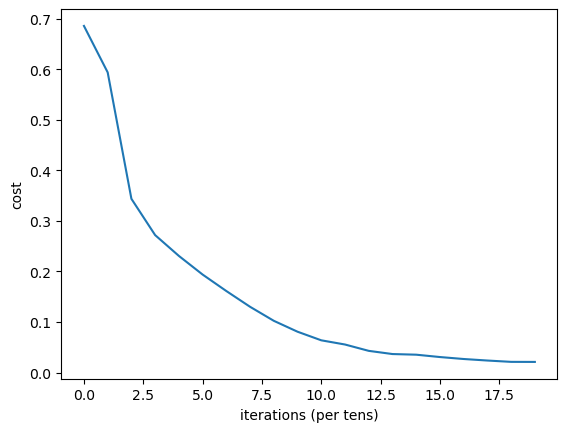



Accuracy on training set is 0.9943357706069946

Accuracy on test set is 0.8460460305213928


In [31]:
plt.plot(np.squeeze(history.history["loss"]))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
# plt.title("Learning rate =" + str(learning_rate))
plt.show()
    
print("\n\nAccuracy on training set is {}".format(history.history["accuracy"][-1]))
print("\nAccuracy on test set is {}".format(results[1]))

In [32]:
predicting = model.predict(val_x, verbose=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


In [33]:
predicted_classes = (predicting > 0.5).astype("int32")

In [34]:
predicted_classes = (predicting > 0.5).astype("int32")

In [35]:
df2 = pd.DataFrame({
    'Text': [x for x in val['text']],
    'Actual Label': [x for x in val['label']],
    'Predicted Label': [x for x in predicted_classes]
})

In [36]:
df2.head(20)

,Text,Actual Label,Predicted Label
0,It's been about 14 years since Sharon Stone aw...,0,[0]
1,someone needed to make a car payment... this i...,0,[0]
2,The Guidelines state that a comment must conta...,0,[0]
3,This movie is a muddled mish-mash of clichés f...,0,[0]
4,Before Stan Laurel became the smaller half of ...,0,[0]
5,This is the best movie I've ever seen! <br /><...,1,[1]
6,The morbid Catholic writer Gerard Reve (Jeroen...,1,[1]
7,"""Semana Santa"" or ""Angel Of Death"" is a very w...",0,[0]
8,Somebody mastered the difficult task of mergin...,1,[1]
9,Why did I waste 1.5 hours of my life watching ...,0,[0]
